# Seminarios de Procesos Gaussianos

### Grupo de procesamiento de la información visual (VIP) 

<div style="text-align: right"> Miguel López Pérez - mlopezp@ugr.es </div>

# GUIÓN V: Procesos Gaussianos para Big Data

En este notebook vamos a abordar (y veremos como se resuelve) una de las principales debilidades de los procesos gaussianos: su escalabilidad para datasets grandes, lo que comúnmente se conoce como *Big Data*. 

Para ello vamos a abordar dos de los métodos más populares que usan inferencia variacional para aproximar el modelo

* el método llamado [*collapsing* de Titsias](https://pdfs.semanticscholar.org/9c13/b87b5efb4bb011acc89d90b15f637fa48593.pdf) 

* y el método *Stochastic Variational Gaussian Procceses* (SVGP) que aparece en el siguiente paper [Gaussian Processes for Big Data](https://arxiv.org/abs/1309.6835). 

Gracias a estas aproximaciones podremos utlizar GPs en datasets que con la aproximación clásica serían inabordables.

In [1]:
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import time

import numpy as np
from scipy.cluster.vq import kmeans2
import sklearn
from sklearn import datasets, model_selection


import gpflow
plt.style.use('ggplot')

### Modelo Variacional

Vamos usar inferencia variacional para aproximar la distribución a posteriori que necesitamos, así como los parámetros del modelo y la localización de las entradas inductoras.

En este caso no podremos calcular la evidencia $\log \mathrm{p}(\mathbf{y}\mid\mathbf{X})$. Sino que maximizaremos una cota inferior de la evidencia, la llamada ELBO, $\mathcal{L}$ , ésta será nuestra nueva función objetivo (mira los apuntes para ver la función exactamente).

## Regresión

Volvemos a un ejemplo en 1D para ilustrar los modelos que vamos a usar. 

Estas primeras funciones serán para pintar los datos y modelos sparse como hemos visto en el notebook anterior.

In [2]:
def plot_Z(m):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(15, 15))
    plt.plot(X, Y, 'o', color = 'black', alpha = 0.023)
    plt.plot(xx, mean, color = 'b', lw=2, label = 'media del proceso gaussiano')
    Z = m.feature.Z.read_value()
    plt.plot(Z, np.zeros(len(Z)), '*', mew=2, color = 'red', label='entradas inductoras estimados')
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='cyan', alpha=0.3)
    plt.xlim(-0.1, 1.1)

Vamos a generar datos en un ejemplo 1D de una función latente $f$. Esta función $f$ tendrá ruido gaussiano $\epsilon$, por tanto, nuestros datos observados serán de la forma: $y = f(x) + \epsilon$, $x\in[0,1]$. 

$$f(x) = \sin(9x) + 0.4 \exp(x-0.7) + 0.5 \cos(69x)+1$$

Tenemos $N=10000$ observaciones de modo que este modelo sería casi prohibitivo para un GP normal. 

Usaremos, obviamente, puntos inductores para maximizar la ELBO. En este ejemplo vamos a ver como podemos abordar este problema con 25 puntos inductores usando tanto el modelo "collapsing" como el estocástico.

[]

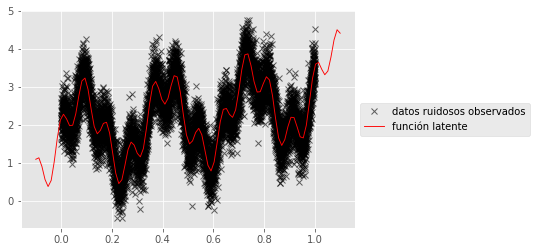

In [3]:
np.random.seed(200)
N = 10000
X = np.random.rand(N,1)
Y = np.sin(19*X) + 0.5*np.cos(69*X)+ 1.4 * np.exp(X-0.7) + np.random.randn(N,1)*0.4+1

N = 100
X_real = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
Y_real = np.sin(19*X_real) + 0.5*np.cos(69*X_real)+ 1.4 * np.exp(X_real-0.7)+1

plt.plot(X, Y, 'x', label='datos ruidosos observados', color = 'black', alpha = 0.6)
plt.plot(X_real, Y_real, color = 'red', lw = 0.9, label='función latente')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

En la siguiente celda vamos a definir unas funciones que nos monitorizarán la optimización de la función objetivo (la ELBO) durante el proceso iterativo.

In [4]:
class Logger(gpflow.actions.Action):
    def __init__(self, model):
        self.model = model
        self.logf = []
        
    def run(self, ctx):
        if (ctx.iteration % 10) == 0:
            # Extract likelihood tensor from Tensorflow session
            likelihood = - ctx.session.run(self.model.likelihood_tensor)
            # Append likelihood value to list
            self.logf.append(likelihood)

def run_adam(model, iterations):
    """
    Utility function running the Adam Optimiser interleaved with a `Logger` action.
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimiser action
    adam = gpflow.train.AdamOptimizer().make_optimize_action(model)
    # Create a Logger action
    logger = Logger(model)
    actions = [adam, logger]
    # Create optimisation loop that interleaves Adam with Logger
    loop = gpflow.actions.Loop(actions, stop=iterations)()
    # Bind current TF session to model
    model.anchor(model.enquire_session())
    return logger


### Modelo "collapsing"

Veamos los resultados obtenidos. También se muestra la ELBO del modelo.

La ELBO del modelo es -17310.292904225178


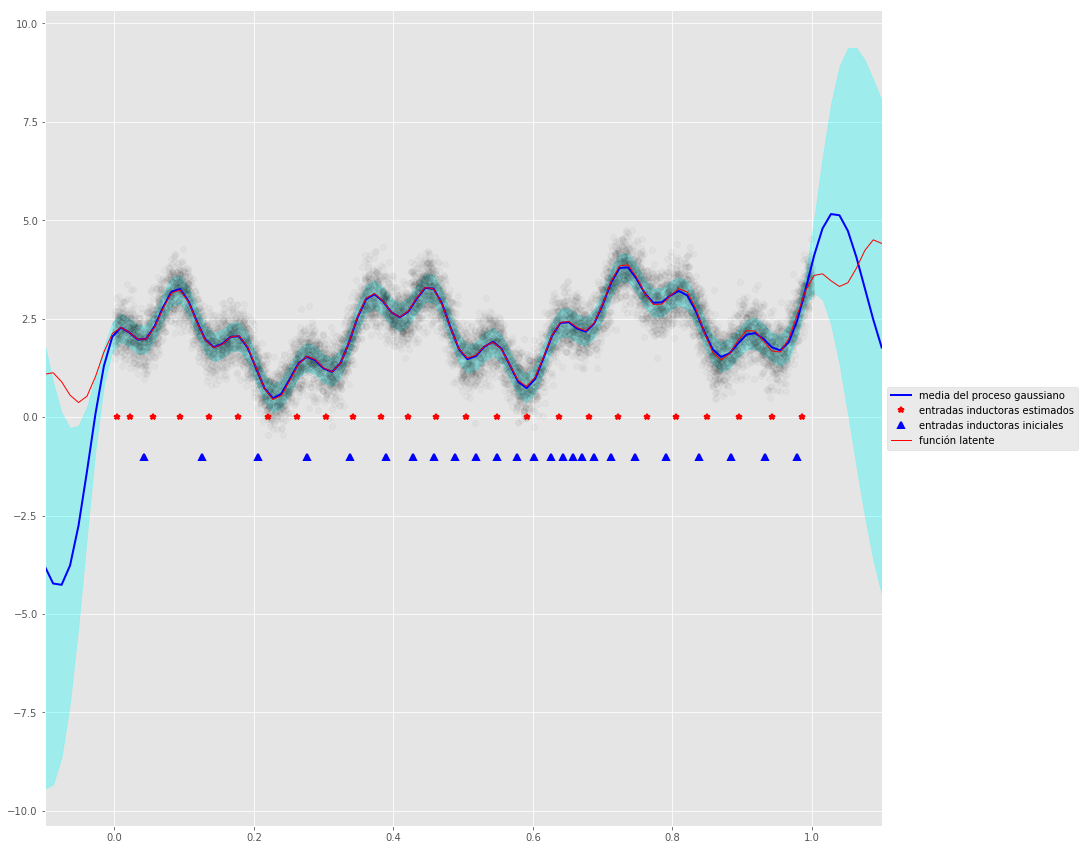

In [5]:
sc = 0.1
var = 10
var_lik = 0.01
M = 25 #Numero de puntos inductores

Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SGPR(X, Y, kern=k, Z = Z)
m.likelihood.variance = var_lik
gpflow.training.AdamOptimizer(0.01).minimize(m, maxiter = 200)

plot_Z(m)
plt.plot(Z, -1 + np.zeros(len(Z)), '^', mew=2, color = 'blue', label='entradas inductoras iniciales')
plt.plot(X_real, Y_real, color = 'r', lw = 1, label='función latente')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()
print('La ELBO del modelo es', m.compute_log_likelihood())


El número de iteraciones del ejemplo anterior fue 200. A continuación vamos a realizar 10000 iteraciones y guardaremos los resultados de la optimización. Además mostramos el tiempo de ejecución.

In [8]:
start = time.time()
Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SGPR(X, Y, kern=k, Z = Z)
m.likelihood.variance = var_lik

logger_collapsing = run_adam(m, gpflow.test_util.notebook_niter(10000))
print('Tiempo de ejecución', time.time()-start)

Tiempo de ejecución 354.01559114456177


### Modelo estocástico

Hacemos lo mismo con el modelo estocástico. En este modelo se pueden usar mini-batches, pero para que trabaje con todos los datos seleccionamos minibatch_size = None.

La ELBO del modelo es -102065.71329752525


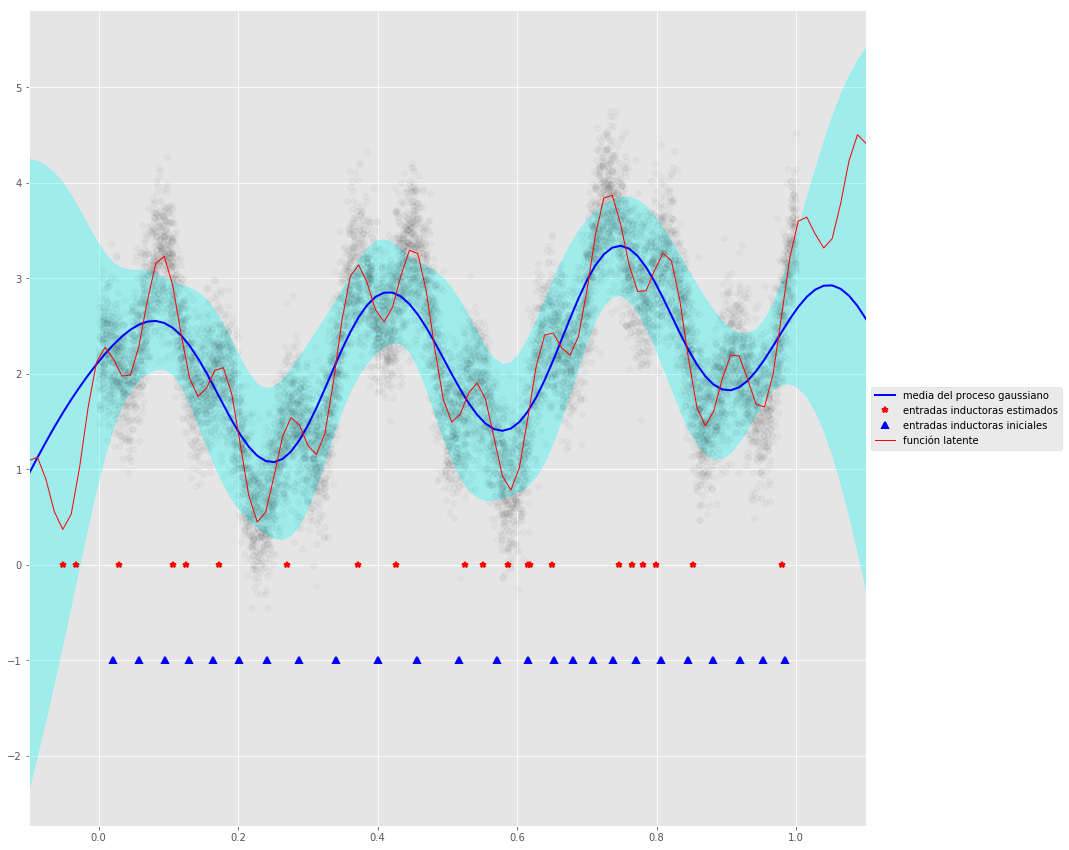

In [9]:
sc = 0.1
var = 10
var_lik = 0.01
M = 25 #Numero de puntos inductores

Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SVGP(X, Y, kern=k, Z = Z, likelihood = gpflow.likelihoods.Gaussian(), minibatch_size=None)
m.likelihood.variance = var_lik
gpflow.training.AdamOptimizer(0.01).minimize(m, maxiter = 200)

plot_Z(m)
plt.plot(Z, -1 + np.zeros(len(Z)), '^', mew=2, color = 'blue', label='entradas inductoras iniciales')
plt.plot(X_real, Y_real, color = 'r', lw = 1, label='función latente')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()
print('La ELBO del modelo es', m.compute_log_likelihood())

Observa que esta ELBO es más pequeña que la anterior con el mismo número de iteraciones (200). 

Veamos cuanto tarda 10000 iteraciones con este modelo. En ambos modelos se tarda alrededor de 6 minutos.

In [10]:
start = time.time()
Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SVGP(X, Y, kern=k, Z = Z, likelihood = gpflow.likelihoods.Gaussian(), minibatch_size=None)
m.likelihood.variance = var_lik

logger_stochastic = run_adam(m, gpflow.test_util.notebook_niter(10000))
print('Tiempo de ejecución', time.time()-start)

Tiempo de ejecución 393.99537920951843


Con los datos guardados de la optimización usando ambos modelos podemos ver la evolución de la ELBO durante las 10000 iteraciones:

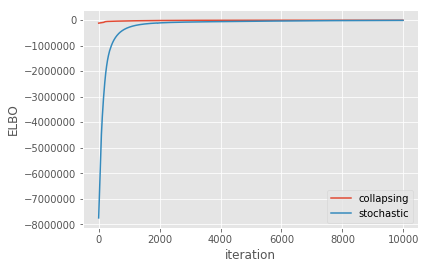

In [11]:
plt.plot(np.arange(0,10000, 10), -np.array(logger_collapsing.logf), label = 'collapsing')
plt.plot(np.arange(0,10000, 10), -np.array(logger_stochastic.logf), label = 'stochastic')
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.legend();

Acerquemos la gráfica para verla mejor:

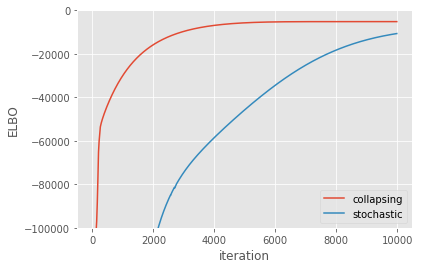

In [12]:
plt.plot(np.arange(0,10000, 10), -np.array(logger_collapsing.logf), label = 'collapsing')
plt.plot(np.arange(0,10000, 10), -np.array(logger_stochastic.logf), label = 'stochastic')
plt.ylim(-100000,0)
plt.xlabel('iteration')
plt.ylabel('ELBO')
plt.legend();

En este experimento hemos usado siempre todos los datos. Hemos visto que el modelo "collapsing" necesita menos iteraciones para obtener una ELBO casi óptima. Sin embargo, con un número suficientemente grande de iteraciones podemos llegar al mismo sitio usando el modelo estocástico.

Recuerda que el orden del "collapsing" es $\mathcal{O}(NM^2)$. Donde $N$ es el número de instancias y $M$ es el  número de puntos inductores. Mientras que en el estocástico es $\mathcal{O}(N_b M^2)$, siendo $N_b$ el tamaño del mini-batch. En este caso hemos usado todo el dataset como mini-batch.

#### Uso de mini-batches

Con la aproximación estocástica podemos calcular el ELBO usando mini-batches. De esta forma hacemos mucho más eficiente la computación. En este primer ejemplo, usamos el dataset entero para calcular el ELBO. Volvemos a definir nuestro modelo (lo inicializamos) de regresión, esta vez seleccionamos en *minibatch_size* el tamaño de mini-batches que queremos.

In [13]:
Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SVGP(X, Y, kern=k, Z = Z, likelihood = gpflow.likelihoods.Gaussian(), minibatch_size=None)
ground_truth = m.compute_log_likelihood()
m = gpflow.models.SVGP(X, Y, kern=k, Z = Z, likelihood = gpflow.likelihoods.Gaussian(), minibatch_size=len(X))

In [14]:
%%timeit
m.compute_log_likelihood()

27.8 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


En este segundo ejemplo, usamos mini-batches de tamaño 100 para calcular el ELBO.

In [15]:
minibatch_size = 100
m.X.set_batch_size(minibatch_size)
m.Y.set_batch_size(minibatch_size)

In [16]:
%%timeit
m.compute_log_likelihood()

5 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


¿Pero perdemos exactitud usando mini-batches? La estimación por mini-batches debería ser un estimador insesgado de la auténtica ELBO. Aquí mostramos el histograma de los valores medios en diferentes evaluaciones. Vemos que las estimaciones por mini-batches se quedan muy cerca del valor real de la ELBO.

In [17]:
evals = [m.compute_log_likelihood() for _ in range(100)]

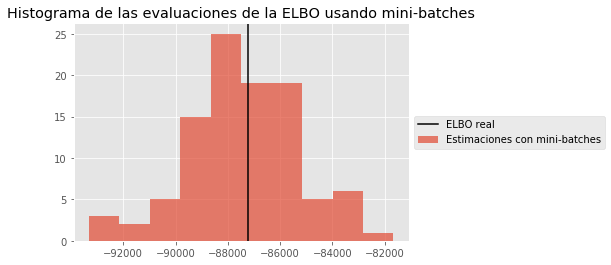

In [18]:
plt.hist(evals, alpha = 0.7, label='Estimaciones con mini-batches')
plt.axvline(ground_truth, c='k', label='ELBO real')
plt.legend()
plt.title('Histograma de las evaluaciones de la ELBO usando mini-batches')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Hemos obtenido usando mini-batches valores de la ELBO muy próximos a cuando usamos todos los datos. La razón para usar mini-batches es por el decrecimiento del tiempo de ejecución para hacer cada paso de optimización, ya que estimar el valor de la función objetivo (ELBO) es menos costoso con menos datos. Veamos gráficamente los valores para distintos tamaños de mini-batches. 

In [19]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(len(X) * mbp)
    m.X.set_batch_size(batchsize)
    m.Y.set_batch_size(batchsize)
    start_time = time.time()
    objs.append([m.compute_log_likelihood() for _ in range(20)])
    times.append(time.time() - start_time)

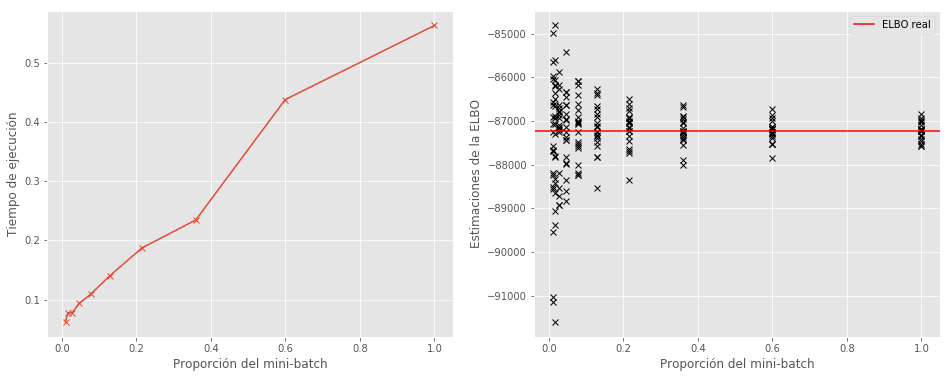

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Proporción del mini-batch")
ax1.set_ylabel("Tiempo de ejecución")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.axhline(ground_truth, c='r', label='ELBO real')
ax2.set_xlabel("Proporción del mini-batch")
ax2.set_ylabel("Estimaciones de la ELBO")
ax2.legend();

¿Por qué no obtenemos un único valores cuando usamos mini-batches del tamaño del conjunto de entrenamiento?

Probemos los mini-batches en el ejemplo de regresión. Conseguiremos un valor similar de la función objetivo ganando bastante eficiencia en la ejecución. En este caso dando 10000 iteraciones tardamos menos de 1 minuto.

In [21]:
start = time.time()
Z = kmeans2(X, M, minit='points')[0]
k = gpflow.kernels.RBF(1, lengthscales=sc, variance = var)
m = gpflow.models.SVGP(X, Y, kern=k, Z = Z, likelihood = gpflow.likelihoods.Gaussian(), minibatch_size=0.1*len(X))
m.likelihood.variance = var_lik

logger_stochastic2 = run_adam(m, gpflow.test_util.notebook_niter(10000))
print('Tiempo de ejecución', time.time()-start)

Tiempo de ejecución 58.03356385231018


Comparamos los entrenamientos del modelo *collapsing* y del estocástico (usando tanto todos los datos a la vez como mini-batches). Observa mientras que en el azul intenso estabamos usando todo el dataset para calcular la ELBO mientras que usando mini-batches estamos usando el 10% para calcular el ELBO (1000 datos). Con este uso de mini-batches se reduce considerablemente el tiempo de ejecución. Además conseguimos valores muy cercanos de la ELBO real por lo que no perdemos efectividad.

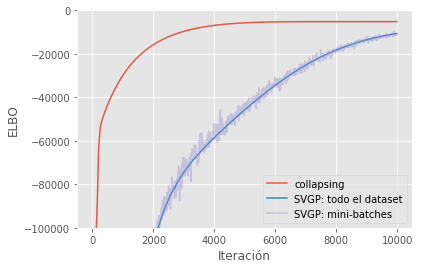

In [22]:
plt.plot(np.arange(0,10000, 10), -np.array(logger_collapsing.logf), alpha = 0.9, label = 'collapsing')
plt.plot(np.arange(0,10000, 10), -np.array(logger_stochastic.logf), alpha = 1,  label = 'SVGP: todo el dataset')
plt.plot(np.arange(0,10000, 10), -np.array(logger_stochastic2.logf), alpha = 0.4, label = 'SVGP: mini-batches')
plt.ylim(-100000,0)
plt.xlabel('Iteración')
plt.ylabel('ELBO')
plt.legend();

### Ejemplo: Diabetes (Regresión)

Volvemos a usar el dataset de diabetes para regresión. En este caso compararemos las métricas con distinto número de puntos inductores. Para este ejemplo hemos usado distintos números de puntos inductores usando el modelo *collapsing*.

En primer lugar, generamos los conjuntos de train y test y ajustamos un modelo de clasificación sin usar puntos inductores. Calculamos el error cuadrático medio y la ELBO del modelo.

In [23]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
print('El tamaño de este dataset es', X.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state = 100)
m = gpflow.models.GPR(X_train, y_train.reshape(-1,1), kern=gpflow.kernels.RBF(X_train.shape[1]) + gpflow.kernels.White(X_train.shape[1], 1e-5))
m.likelihood.variance = 0.1
gpflow.train.ScipyOptimizer().minimize(m, maxiter=500)
print('La ELBO del modelo es', m.compute_log_likelihood())
pred_gp, var = m.predict_y(X_test)
mse_gp = sklearn.metrics.mean_squared_error(y_test, pred_gp)
print('El mse de GP es ', mse_gp)

El tamaño de este dataset es (442, 10)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1464.023135
  Number of iterations: 57
  Number of functions evaluations: 65


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1464.023135
  Number of iterations: 57
  Number of functions evaluations: 65


La ELBO del modelo es -1464.0231354481987
El mse de GP es  2494.799690113115


Vamos a usar distintos números de puntos inductores $M\in[10,200,250,300,400]$. Para cada caso calcularemos el error cuadrático medio y la ELBO.

In [24]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True)
print('El tamaño de este dataset es', X.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state = 100)

mse_sgp_list = []
ind_points = [10, 100, 250, 300, 400]

for M in ind_points:
    Z = kmeans2(X, M, minit='points')[0]
    m = gpflow.models.SGPR(X_train, y_train.reshape(-1,1), kern=gpflow.kernels.RBF(X_train.shape[1]) + gpflow.kernels.White(X_train.shape[1], 1e-5), Z = Z)
    m.likelihood.variance = 0.1
    gpflow.train.ScipyOptimizer().minimize(m, maxiter=500)
    pred_sgp, var = m.predict_y(X_test)
    mse_sgp = sklearn.metrics.mean_squared_error(y_test, pred_sgp)
    print('La ELBO del modelo es', m.compute_log_likelihood(), ' con ', M, ' puntos inductores \n')
    print('El mse de SGP es ', mse_sgp, ' con ', M, ' puntos inductores \n')
    mse_sgp_list.append(mse_sgp)

El tamaño de este dataset es (442, 10)
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1542.150107
  Number of iterations: 108
  Number of functions evaluations: 114


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 1542.150107
  Number of iterations: 108
  Number of functions evaluations: 114


La ELBO del modelo es -1542.1501068306752  con  10  puntos inductores 

El mse de SGP es  5284.253122760573  con  10  puntos inductores 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.816116
  Number of iterations: 110
  Number of functions evaluations: 141


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.816116
  Number of iterations: 110
  Number of functions evaluations: 141


La ELBO del modelo es -1488.8161160543073  con  100  puntos inductores 

El mse de SGP es  2580.3826558235146  con  100  puntos inductores 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.973654
  Number of iterations: 85
  Number of functions evaluations: 95


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.973654
  Number of iterations: 85
  Number of functions evaluations: 95


La ELBO del modelo es -1488.9736544057143  con  250  puntos inductores 

El mse de SGP es  2582.08692347433  con  250  puntos inductores 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.686131
  Number of iterations: 75
  Number of functions evaluations: 83


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1488.686131
  Number of iterations: 75
  Number of functions evaluations: 83


La ELBO del modelo es -1488.6861309044  con  300  puntos inductores 

El mse de SGP es  2578.9557388349986  con  300  puntos inductores 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1485.754833
  Number of iterations: 332
  Number of functions evaluations: 414


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1485.754833
  Number of iterations: 332
  Number of functions evaluations: 414


La ELBO del modelo es -1485.7548327844656  con  400  puntos inductores 

El mse de SGP es  2528.4857090136957  con  400  puntos inductores 



Pintamos en un gráfico los resultados de error cuadrático medio. La línea naranja corresponde al modelo completo sin puntos inductores.

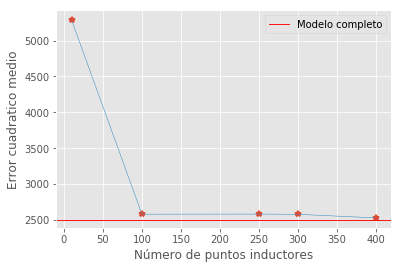

In [25]:
plt.figure()
plt.plot(ind_points, mse_sgp_list, '*', lw = 0.5, mew=2)
plt.plot(ind_points, mse_sgp_list,  lw = 0.5, mew=2)
plt.axhline(y=mse_gp, color='r', linestyle='-', lw = 0.9,  label='Modelo completo')
plt.xlabel('Número de puntos inductores')
plt.ylabel('Error cuadratico medio')
plt.legend()

## Clasificación

En clasificación para modelos Sparse basados en Procesos Gaussianos solo está el modelo *Stochastic Variational Gaussian Processes* (SVGP). Este modelo que previamente lo hemos usado en regresión cuenta también con el uso de mini-batches. Dependiendo de nuestro problema deberemos usar una *likelihood* u otra, para problemas de clasificación binaria usaremos *Bernoulli* mientras que para multiclase, *Multiclass*.

Funciones para pintar los modelos en 2D:

In [26]:
def gridParams():
    mins = [-0.75,-1.5 ]
    maxs = [ 2.5, 1.25 ]
    nGrid = 50
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot

def plot(m, ax, Xtrain, Ytrain):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'ko', color='g', alpha=0.31)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'ko', color='b', alpha=0.31)
    if hasattr(m, 'feature') and hasattr(m.feature, 'Z'):
        Z = m.feature.Z.read_value()
        ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
        ax.set_title('m={}'.format(Z.shape[0]))
    else:
        ax.set_title('full')
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.1], colors='b', linewidths=1.8, zorder=100)
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.9], colors='g', linewidths=1.8, zorder=100)

Con el ejemplo en 2D del dataset de las lunas vamos a ver como se ajustan los modelos sparse. Para ello usamos $M\in[5,10,50,100]$ puntos inductores. Usamos el modelo SVGP sin usar mini-batches y una verosimilitud de tipo Bernoulli.

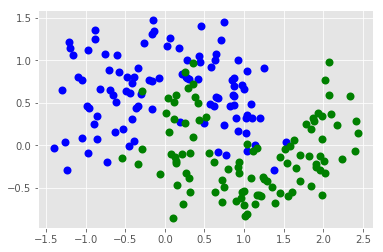

In [27]:
X, y = sklearn.datasets.make_moons(n_samples = 200, noise = 0.3, random_state = 110)
y = y.reshape(-1,1)
plt.figure()
plt.plot(X[:,0][y[:,0]==0], X[:,1][y[:,0]==0], 'ko', mew=2, color = 'b')
plt.plot(X[:,0][y[:,0]==1], X[:,1][y[:,0]==1], 'ko', mew=2, color = 'g')
plt.show()

In [28]:
m = gpflow.models.VGP(X, y,
                      kern=gpflow.kernels.RBF(2),
                      likelihood=gpflow.likelihoods.Bernoulli())
gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)


models = []
models.append(m)

ind_points = [5, 10, 50, 100]

for M in ind_points:
    Z = kmeans2(X, M, minit='points')[0]
    m = gpflow.models.SVGP(X, y,
                      kern=gpflow.kernels.RBF(2),
                      likelihood=gpflow.likelihoods.Bernoulli(), Z = Z)
    gpflow.train.ScipyOptimizer(options=dict(maxiter=200)).minimize(m)
    models.append(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.785646
  Number of iterations: 217
  Number of functions evaluations: 229


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.785646
  Number of iterations: 217
  Number of functions evaluations: 229


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.290738
  Number of iterations: 284
  Number of functions evaluations: 317


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 70.290738
  Number of iterations: 284
  Number of functions evaluations: 317


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 58.058088
  Number of iterations: 1000
  Number of functions evaluations: 1150


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 58.058088
  Number of iterations: 1000
  Number of functions evaluations: 1150


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.786140
  Number of iterations: 442
  Number of functions evaluations: 493


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.786140
  Number of iterations: 442
  Number of functions evaluations: 493


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.785685
  Number of iterations: 357
  Number of functions evaluations: 388


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 56.785685
  Number of iterations: 357
  Number of functions evaluations: 388


A continuación vamos a dibujar el modelo completo (full, es decir, sin usar puntos inductores) y los modelos obtenidos con distinto número de puntos inductores. Los puntos negros son las localizaciones de las entradas inductoras estimadas. La línea negra es la frontera que separa la probabilidad 0.5 de pertenecer a cada clase. Además hay dos líneas más la azul y la verde que señalan las probabilidades de 0.1 y 0.9 respectivamente. Esto nos indica cual es la zona en la que está seguro al 90% de pertenecer a cada clase. Prueba a utilizar mini-batches en este ejemplo.

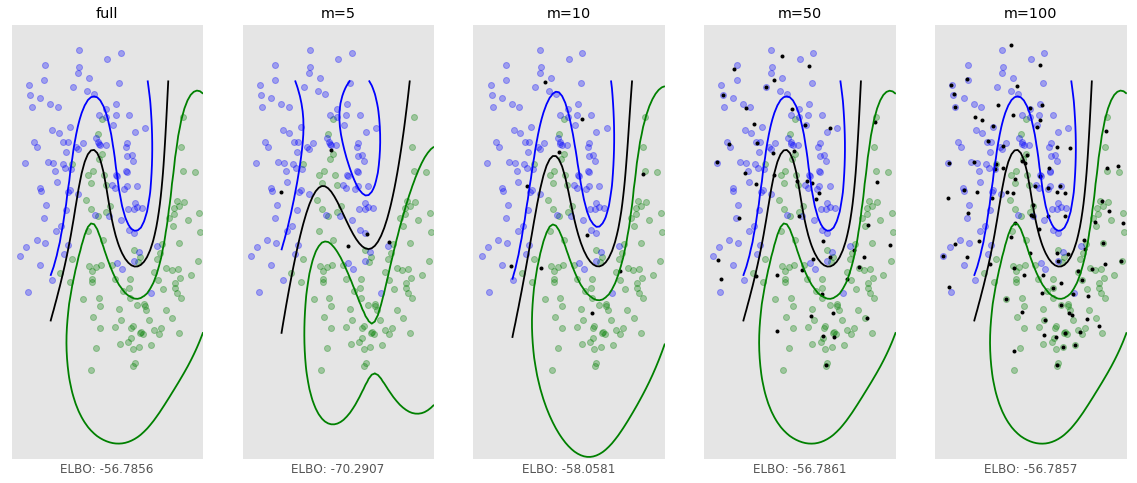

In [29]:
# make plots.
fig, axes = plt.subplots(1, len(models), sharex=True, sharey=True, figsize=(20, 8))
for i, m in enumerate(models):
    plot(m, axes[i], X, y)
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_xlabel('ELBO: {0:.4f}'.format(m.compute_log_likelihood()))

### Ejemplo: Breast Cancer (clasificación binaria)

Volvemos al mismo ejemplo del notebook anterior. Esta vez veremos como según el número de puntos inductores escogidos influirá en el accuracy de nuestro modelo. Recordamos que el accuracy es la tasa de acierto:
$$Accuracy=\frac{TP+TN}{N}$$

Usamos el SVGP sin usar mini-batches para los modelos sparse. Además lo compararemos con el modelo sin puntos inductores (full) al igual que hicimos en regresión.

In [30]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
print('El tamaño de este dataset es', X.shape)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state = 100)
m = gpflow.models.VGP(X_train, y_train.reshape(-1,1), kern=gpflow.kernels.RBF(X_train.shape[1], ARD = True), likelihood=gpflow.likelihoods.Bernoulli())
gpflow.train.AdamOptimizer(0.1).minimize(m, maxiter=300)
gpflow.train.AdamOptimizer(0.01).minimize(m, maxiter=300)
print('La ELBO del modelo es', m.compute_log_likelihood())
pred_gp = m.predict_y(X_test)
pred_gp = [1 if x> 0.5 else 0 for x in pred_gp[0]]
acc_gp = sklearn.metrics.accuracy_score(y_test, pred_gp)

El tamaño de este dataset es (569, 30)
La ELBO del modelo es -125.33012469027435


In [31]:
acc_sgp_list = []
ind_points = [10, 40, 100, 160, 250]

for M in ind_points:
    Z = kmeans2(X_train, M, minit='points')[0]
    m = gpflow.models.SVGP(X_train, y_train.reshape(-1,1), kern=gpflow.kernels.RBF(X_train.shape[1], ARD = True), Z = Z, likelihood=gpflow.likelihoods.Bernoulli())
    m.likelihood.variance = 0.1
    gpflow.train.AdamOptimizer(0.1).minimize(m, maxiter=300)
    gpflow.train.AdamOptimizer(0.01).minimize(m, maxiter=300)
    pred_sgp = m.predict_y(X_test)
    pred_sgp = [1 if x> 0.5 else 0 for x in pred_sgp[0]]
    acc_sgp = sklearn.metrics.accuracy_score(y_test, pred_sgp)
    print('La ELBO del modelo es', m.compute_log_likelihood(), ' con ', M, ' puntos inductores \n')
    print('El accuracy de SGP es ', acc_sgp, ' con ', M, ' puntos inductores \n')
    acc_sgp_list.append(acc_sgp)

La ELBO del modelo es -236.4434495950266  con  10  puntos inductores 

El accuracy de SGP es  0.3815789473684211  con  10  puntos inductores 

La ELBO del modelo es -236.44344959919408  con  40  puntos inductores 

El accuracy de SGP es  0.3815789473684211  con  40  puntos inductores 

La ELBO del modelo es -132.99548783987348  con  100  puntos inductores 

El accuracy de SGP es  0.9780701754385965  con  100  puntos inductores 

La ELBO del modelo es -134.43696731454705  con  160  puntos inductores 

El accuracy de SGP es  0.9692982456140351  con  160  puntos inductores 

La ELBO del modelo es -126.37280305330788  con  250  puntos inductores 

El accuracy de SGP es  0.9692982456140351  con  250  puntos inductores 



Pintamos el accuracy según el número de puntos inductores escogidos.

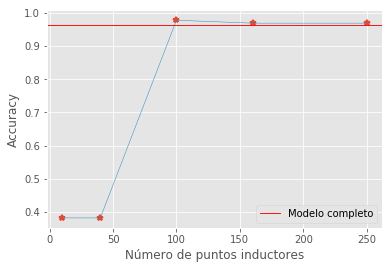

In [32]:
plt.figure()
plt.plot(ind_points, acc_sgp_list, '*', lw = 0.5, mew=2)
plt.plot(ind_points, acc_sgp_list,  lw = 0.5, mew=2)
plt.axhline(y=acc_gp, color='r', linestyle='-', lw = 0.9,  label='Modelo completo')
plt.xlabel('Número de puntos inductores')
plt.ylabel('Accuracy')
plt.legend()

In [33]:
acc_gp

0.9649122807017544

Observa que el accuracy decae aumentando el número de puntos inductores. ¿Cuál sería tu justificación?

### Ejemplo: MNIST (clasificación multiclase)

Vamos a hacer un ejemplo con el famoso dataset MNIST. Es muy conocido en el campo de clasificación de imágenes y es usado para evaluar algoritmos. Consiste en dígitos de 0 a 9 manuscritos. La clase es el número al que se corresponde. Las imágenes tienen una resolución de $28\times 28$ y están en escala de grises.

In [35]:
with warnings.catch_warnings():   
    warnings.simplefilter("ignore")
    def get_mnist_data(data_path='/data'):
        from tensorflow.examples.tutorials.mnist import input_data
        mnist = input_data.read_data_sets(data_path+'/MNIST_data/', one_hot=False)

        X, Y = mnist.train.next_batch(mnist.train.num_examples)
        Xval, Yval = mnist.validation.next_batch(mnist.validation.num_examples)
        Xtest, Ytest = mnist.test.next_batch(mnist.test.num_examples)

        Y, Yval, Ytest = [np.array(y, dtype=float)[:, None] for y in [Y, Yval, Ytest]]

        X = np.concatenate([X, Xval], 0)
        Y = np.concatenate([Y, Yval], 0)

        return X.astype(float), Y.astype(float), Xtest.astype(float), Ytest.astype(float)
    
    X, Y, Xs, Ys = get_mnist_data()

Extracting /data/MNIST_data/train-images-idx3-ubyte.gz
Extracting /data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /data/MNIST_data/t10k-labels-idx1-ubyte.gz


Podemos ver a continuación algunos ejemplos de nuestro dataset.

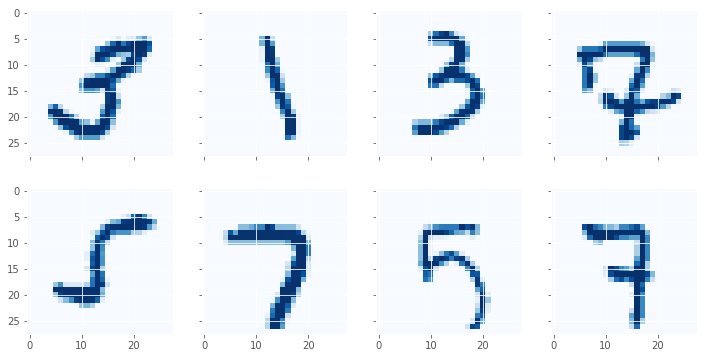

In [36]:
f, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
axes[0,0].imshow(X[0].reshape(28,28), cmap = 'Blues')
axes[0,1].imshow(X[1].reshape(28,28), cmap = 'Blues')
axes[0,2].imshow(X[2].reshape(28,28), cmap = 'Blues')
axes[0,3].imshow(X[3].reshape(28,28), cmap = 'Blues')
axes[1,0].imshow(X[5].reshape(28,28), cmap = 'Blues')
axes[1,1].imshow(X[6].reshape(28,28), cmap = 'Blues')
axes[1,2].imshow(X[7].reshape(28,28), cmap = 'Blues')
axes[1,3].imshow(X[8].reshape(28,28), cmap = 'Blues')

Intentamos ajustar un modelo VGP como en el notebook anterior, pero... obtenemos un error de memoria! Los datos de training tienen una dimensionalidad de 60.000 $\times$ 784. Afortunadamente podemos acudir a los procesos gaussianos sparse, en concreto al variacional usando mini-batches para acelerar la computación.

In [37]:
m_gp = gpflow.models.VGP(X, Y, gpflow.kernels.RBF(784, lengthscales=2., variance=2.), gpflow.likelihoods.MultiClass(10), num_latent=10)

MemoryError: 

In [38]:
#Modelo con 100 puntos inductores
M = 100
Z = kmeans2(X, M, minit='points')[0]

m_sgp = gpflow.models.SVGP(X, Y, gpflow.kernels.RBF(784, lengthscales=2., variance=2.), gpflow.likelihoods.MultiClass(10), Z = Z, minibatch_size=1000, whiten=True, num_latent=10)

In [39]:
#Optimización del modelo
gpflow.training.AdamOptimizer(0.01).minimize(m_sgp, maxiter=100)

In [40]:
#Evaluando el test
pred_sgp = m_sgp.predict_y(Xs)
pred_sgp = np.argmax(pred_sgp[0], 1)
acc = sklearn.metrics.accuracy_score(Ys, pred_sgp)
print("El accuracy de nuestro modelo es ", acc)

El accuracy de nuestro modelo es  0.9083


Si añadimos más puntos inductores o iteraciones al proceso de optimización conseguiremos un mayor accuracy a cambio de ralentizar el entrenamiento. Ya que con este tamaño de mini-batch y el número de iteraciones hemos visto 100000 datos, es decir, en el proceso de optimización no hemos llegado ni a ver el dataset completo dos veces.